In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import shutil
import os
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval

/home/max/.pyenv/versions/3.9.14/envs/hloc39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [3]:
images = Path('datasets/Brighton/images/')

outputs = Path('outputs/sfm-Brighton/')
sfm_pairs = outputs / 'brighton-pairs-netvlad.txt'
sfm_dir = outputs / 'brighton-sfm_superpoint+superglue'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Download the dataset
The dataset is simply a set of images.
 
????? The intrinsic parameters will be extracted from the EXIF data and refined with SfM. ????

In [4]:
if not images.exists():
    !gdown 'https://drive.google.com/drive/folders/1tKiXh5M9T6cjD9Pf6c3Ent0DPjgYxPzF' --folder -O datasets/
    os.makedirs(images)
    source_dir = 'datasets/drone_dataset_brighton_beach-master/drone_dataset_brighton_beach-master/images/'
    target_dir = images
    file_names = os.listdir(source_dir)
    for file_name in file_names:
        shutil.move(os.path.join(source_dir, file_name), target_dir)

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [5]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)

[2022/09/27 15:57:55 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/09/27 15:57:55 hloc INFO] Found 18 images in root datasets/Brighton/images.
100%|██████████| 18/18 [00:09<00:00,  1.85it/s]
[2022/09/27 15:58:18 hloc INFO] Finished exporting features.
[2022/09/27 15:58:18 hloc INFO] Extracting image pairs from a retrieval database.
[2022/09/27 15:58:18 hloc INFO] Found 90 pairs.


## Extract and match local features

In [7]:
feature_path = extract_features.main(feature_conf, images, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2022/09/27 16:04:45 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/09/27 16:04:45 hloc INFO] Found 18 images in root datasets/Brighton/images.


Loaded SuperPoint model


100%|██████████| 18/18 [00:02<00:00,  6.23it/s]
[2022/09/27 16:04:48 hloc INFO] Finished exporting features.
[2022/09/27 16:04:48 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 57/57 [00:12<00:00,  4.56it/s]
[2022/09/27 16:05:01 hloc INFO] Finished exporting matches.


## 3D reconstruction
Run COLMAP on the features and matches.

In [8]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2022/09/27 16:05:12 hloc INFO] Creating an empty database...
[2022/09/27 16:05:12 hloc INFO] Importing images into the database...
[2022/09/27 16:05:15 hloc INFO] Importing features into the database...
100%|██████████| 18/18 [00:00<00:00, 692.14it/s]
[2022/09/27 16:05:15 hloc INFO] Importing matches into the database...
100%|██████████| 90/90 [00:00<00:00, 938.08it/s]
[2022/09/27 16:05:15 hloc INFO] Performing geometric verification of the matches...
[2022/09/27 16:05:16 hloc INFO] Running 3D reconstruction...
[2022/09/27 16:05:27 hloc INFO] Reconstructed 1 model(s).
[2022/09/27 16:05:27 hloc INFO] Largest model is #0 with 18 images.
[2022/09/27 16:05:27 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 18
	num_cameras = 1
	num_points3D = 2151
	num_observations = 7690
	mean_track_length = 3.57508
	mean_observations_per_image = 427.222
	mean_reprojection_error = 1.42196
	num_input_images = 18


## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

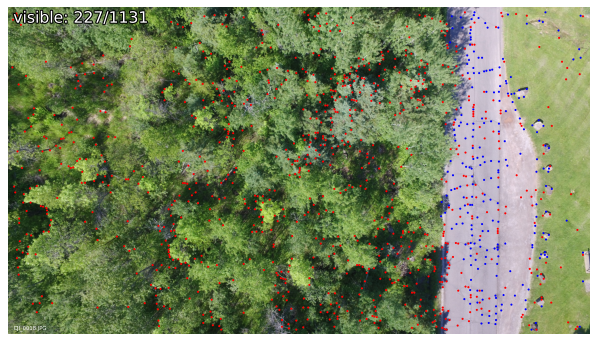

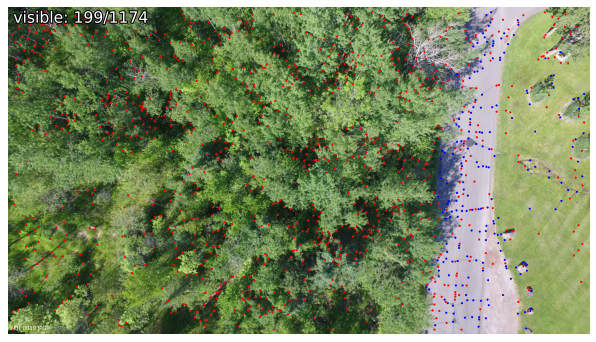

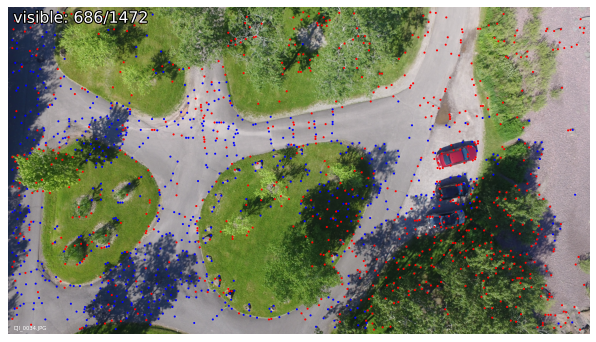

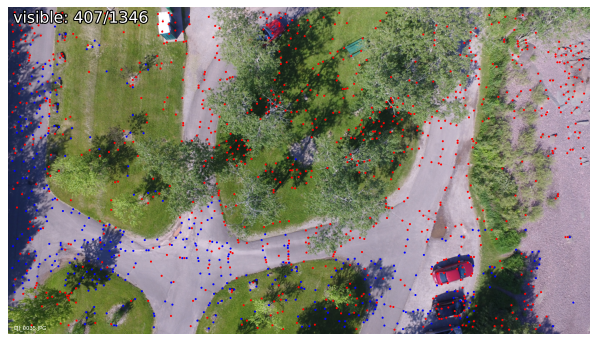

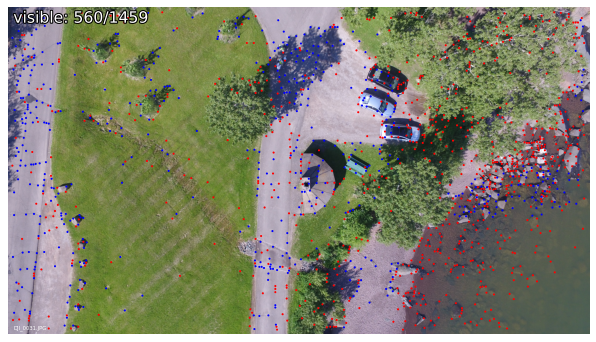

In [9]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

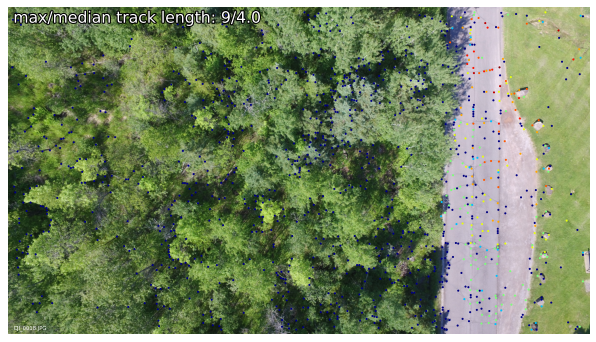

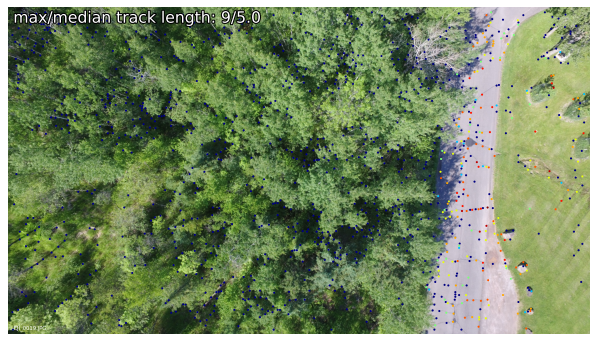

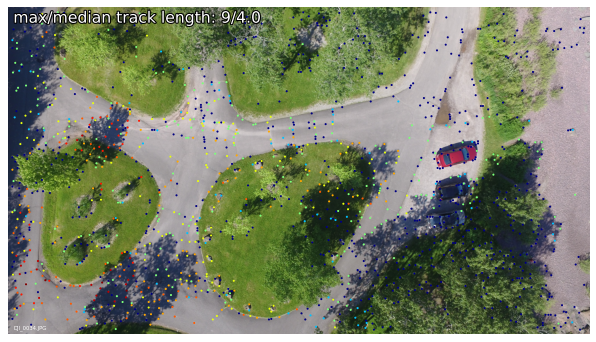

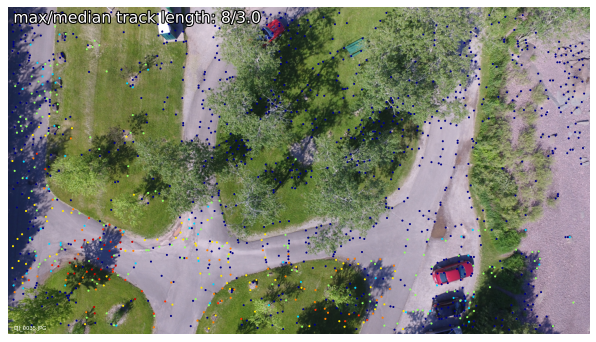

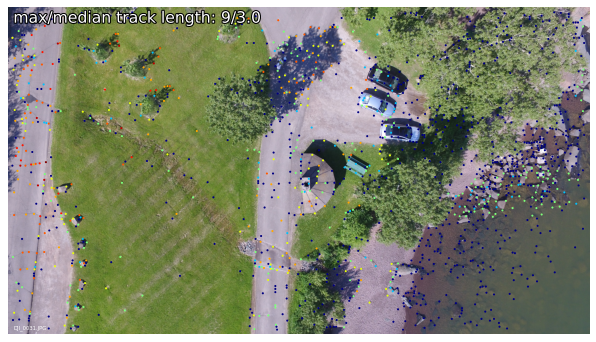

In [10]:
visualization.visualize_sfm_2d(model, images, color_by='track_length', n=5)

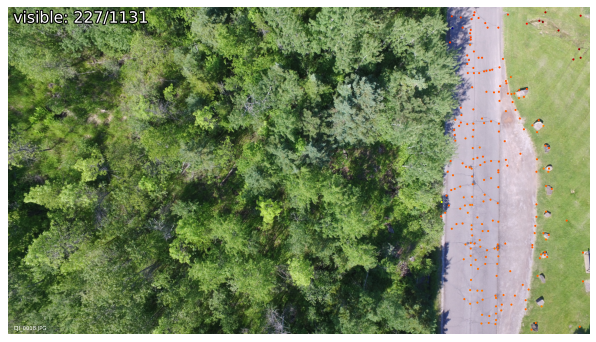

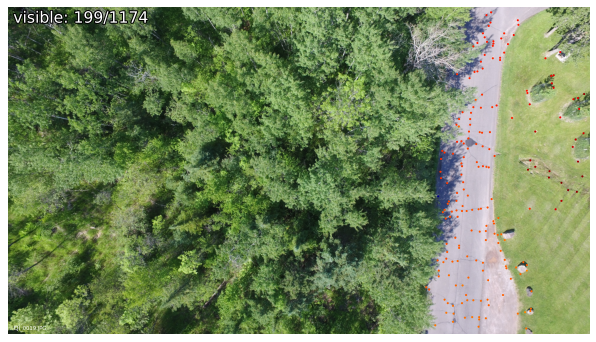

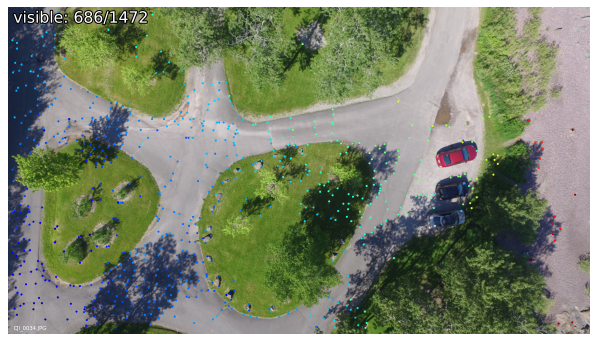

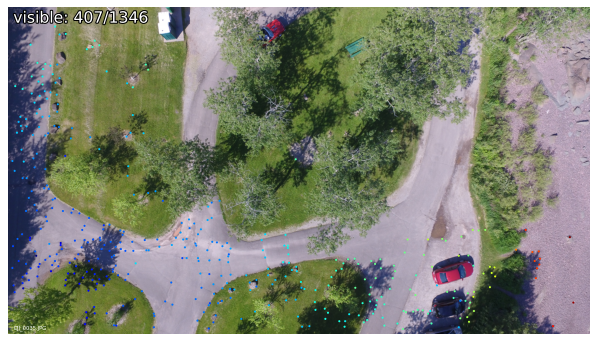

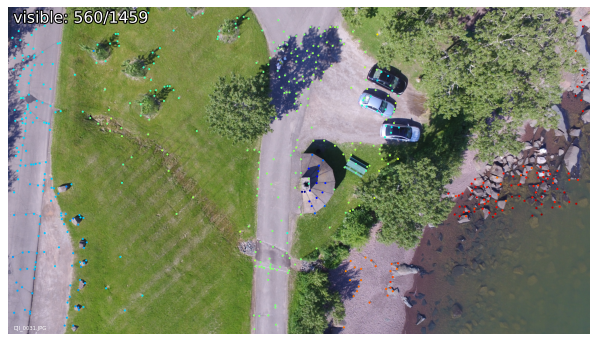

In [11]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=5)